## License Information
---

This file is distributed as part of `swprocess`, a Python package for surface wave processing.

    Copyright (C) 2020 Joseph P. Vantassel (jvantassel@utexas.edu)

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <https: //www.gnu.org/licenses/>.
    
## About _swprocess_ and this notebook
---

`swprocess` is a Python package for surface wave processing. `swprocess` was developed by
Joseph P. Vantassel under the supervision of Professor Brady R. Cox at The University of
Texas at Austin.

If you use _swprocess_ in your research or consulting, we ask you please cite the following:

__TBD__

<!-- >Joseph Vantassel. (2020). jpvantassel/hvsrpy: latest (Concept). Zenodo.
[http://doi.org/10.5281/zenodo.3666956](http://doi.org/10.5281/zenodo.3666956)
 _Note: For software, version specific citations should be preferred to
general concept citations, such as that listed above. To generate a version
specific citation for `hvsrpy`, please use the citation tool on the `hvsrpy`
[archive](http://doi.org/10.5281/zenodo.3666956)._
 -->

<!-- The automated frequency-domain window-rejection algorithm and log-normal statistics
implemented in `hvsrpy` were developed by Tianjian Cheng under the supervision of
Professor Brady R. Cox at The University of Texas at Austin. To
recognize their original work please cite the follwing:

> Cox, B. R., Cheng, T., Vantassel, J. P., and Manuel, L. (2020). “A statistical
> representation and frequency-domain window-rejection algorithm for single-station
> HVSR measurements.” Geophysical Journal International, 221(3), 2170-2183.

This notebook also provides automatic checking of the SESAME (2004) reliability
and clarity critera. To recognize their original work please also cite the following:

> SESAME. (2004). Guidelines for the Implementation of the H/V Spectral Ratio Technique on Ambient Vibrations
> Measurements, Processing, and Interpretation. European Commission - Research General Directorate, 62,
> European Commission - Research General Directorate.
 -->
 
## Getting Started
---
1. Install _swprocess_ and its dependencies, with `pip install swprocess`. If you are not familiar with `pip`, a useful tutorial can be found [here](https://jpvantassel.github.io/python3-course/#/intro/pip). __(~3 minutes)__ 

__TBD__

Happy Processing!

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import swprocess
import swprepost

## Input
---

### Files

In [2]:
# File(s) to import.
fnames_set = [
    ["../masw/peaks_masw.json"],
    ["../mam/mam_rayleigh_array2.json"]
    ]

### Plot Settings

In [3]:
# Domains in which to plot the experimental dispersion data.
domains = [
    ["frequency", "velocity"],
    ["wavelength", "velocity"],
]

# Colors (in hexidecimal) one per `fnames_set` entry.
colors = ["#acacef", "#efacef"]

# Labels one per `fnames_set` entry.
labels = ["MASW - R0", "MAM - C50"]

## View Raw Data
---

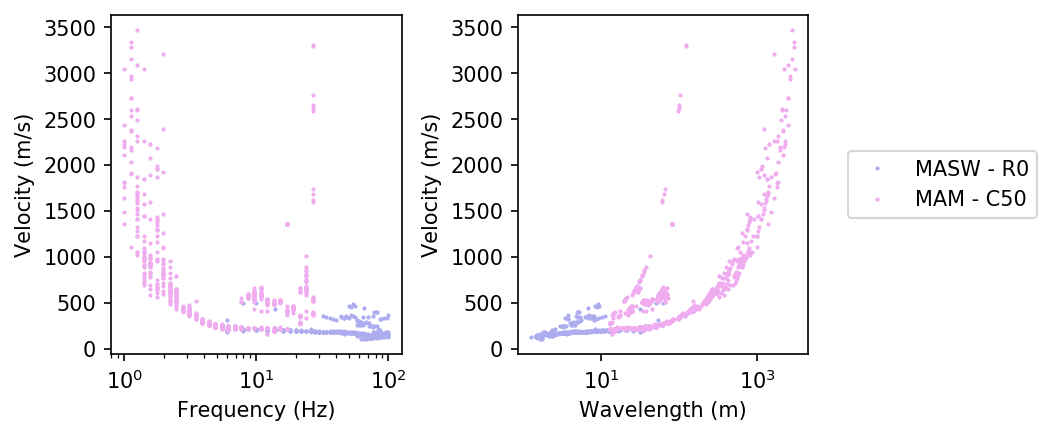

In [4]:
%matplotlib inline
xtype = [x for x, _ in domains]
ytype = [y for _, y in domains]

fig, axs = plt.subplots(ncols=len(xtype), figsize=(6,3), dpi=150, gridspec_kw=dict(wspace=0.4))
suites = []
for fnames, color, label in zip(fnames_set, colors, labels):
    peaksuite = swprocess.PeaksSuite.from_json(fnames=fnames)
    peaksuite.plot(xtype=xtype, ax=axs, ytype=ytype, plot_kwargs=dict(color=color, label=label))
    suites.append(peaksuite)
    
axs[-1].legend(bbox_to_anchor = (1.1, 0.5), loc="center left")

plt.show()

## Settings for Interactive Trimming
---

### Workflow

In [5]:
# Workflow for interactive trimming {"individual", "together"}, "individual" is recommended.
workflow = "individual" 

### Array Resolution Limits

In [6]:
# Resolution limits, one per entry in fnames_set. Ingored if workflow="together".
individual_resolution_limits = [
    ["wavelength", (2, 50)],
    ["wavenumber", (0.103/2, 0.246*2)],
    ]

# Overall minimumm and maximum array resolution, only one entry permitted.
overall_resolution_limits = ["wavenumber", (0.103/2, 2*np.pi/2)]

### Bulk Trimming

In [7]:
# Bulk remove points outside of the specified screening criteria. Use `None` for one sided intervals. Multiple entries permitted.
bulk_trimming_limits = {
    "velocity" : [None, 2500],
    "wavelength" : [None, 1000]
}

## Perform Interactive Trimming
---

Enter (0 to quit, 1 to continue, 2 to undo):  1
Enter (0 to quit, 1 to continue, 2 to undo):  0
Enter (0 to quit, 1 to continue, 2 to undo):  1
Enter (0 to quit, 1 to continue, 2 to undo):  0
Enter (0 to quit, 1 to continue, 2 to undo):  0


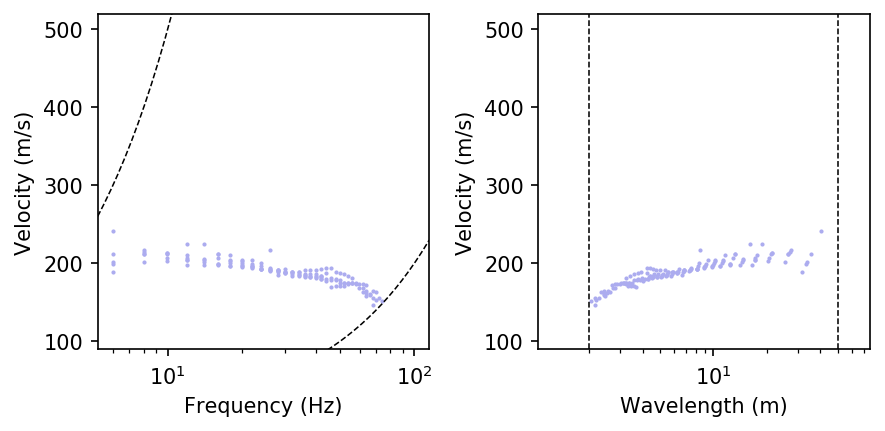

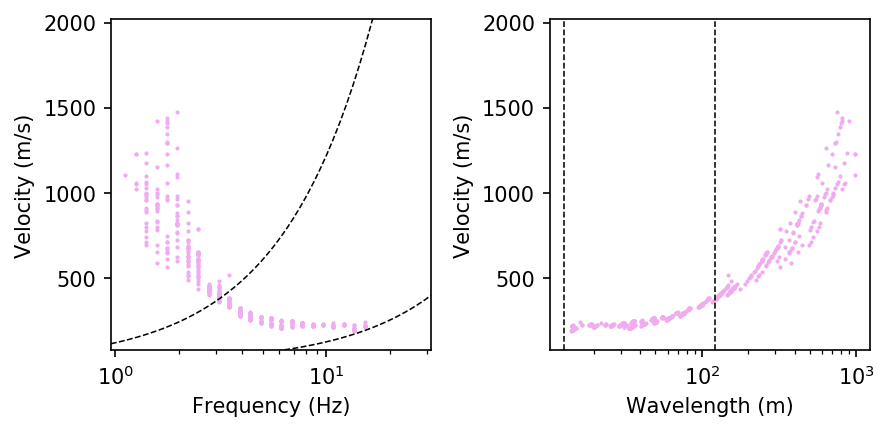

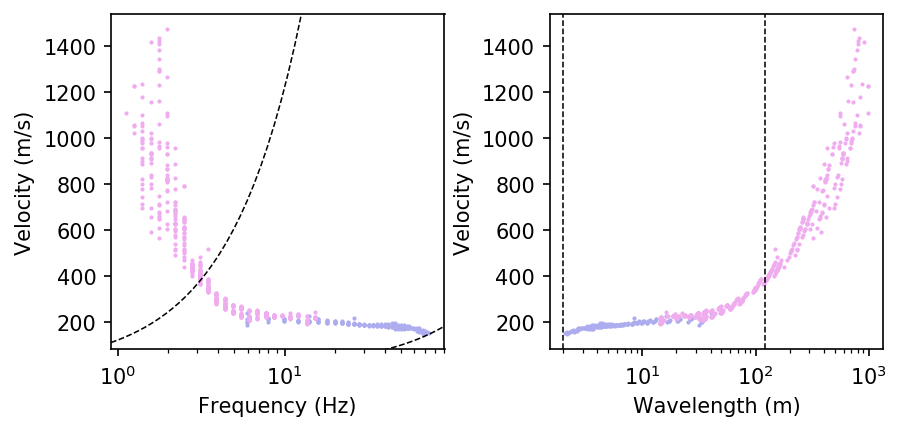

In [8]:
%matplotlib qt5
for suite in suites:
    for attribute, limits in bulk_trimming_limits.items():
        suite.blitz(attribute, limits)

if workflow == "individual":
    for suite, color, label, _resolution_limits in zip(suites, colors, labels, individual_resolution_limits):
        suite.interactive_trimming(xtype=xtype, ytype=ytype, plot_kwargs=dict(color=color, label=label), resolution_limits=_resolution_limits)
    
master_suite = swprocess.PeaksSuite.from_peaksuite(suites)
_colors, _labels = [], []
for color, label, suite in zip(colors, labels, suites):
    for _ in range(len(suite)):
        _colors.append(color)
        _labels.append(label)
        label = None
master_suite.interactive_trimming(xtype=xtype, ytype=ytype, plot_kwargs=dict(color=_colors, label=_labels), resolution_limits=overall_resolution_limits)

## Plot Data Post Trimming
---

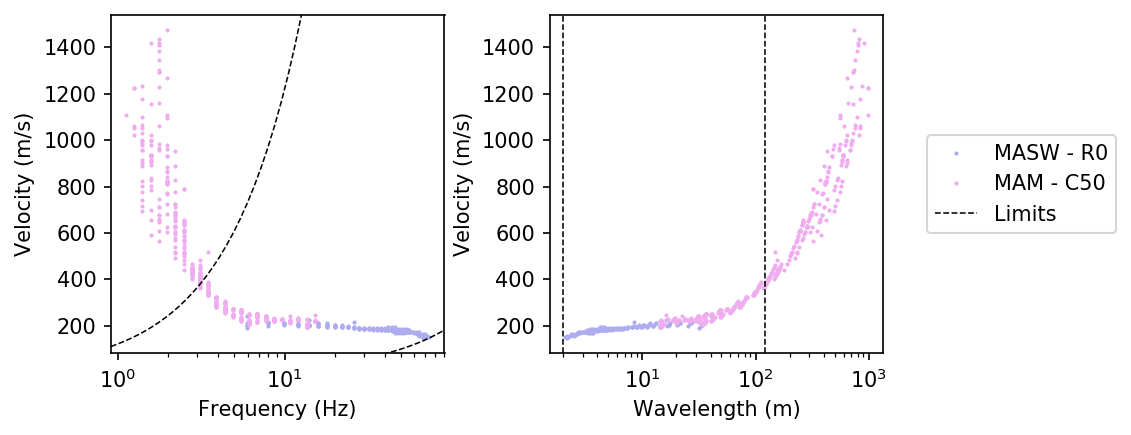

In [15]:
%matplotlib inline
fig, axs = master_suite.plot(xtype=xtype, ytype=ytype, plot_kwargs=dict(color=_colors, label=_labels))


for ax, _xtype, _ytype in zip(axs, xtype, ytype):
    ax.autoscale(enable=False)
    attribute, limits = overall_resolution_limits
    master_suite.plot_resolution_limits(ax=ax, xtype=_xtype, ytype=_ytype, attribute=attribute, limits=limits, plot_kwargs=dict(label="Limits"))
    
axs[-1].legend(bbox_to_anchor = (1.1, 0.5), loc="center left")

plt.show()

## Plot Final Statistics
---

- Number of points

In [ ]:
# xdomain = "wavelength"
# ydomain = "velocity"
# xmin, xmax = 1, 100
# nx = 30
# xspace = "log"
# missing_data_procedure = "ignore"
# ignore = ["corr"]

## Write to `.json`
---

## Write to `.target`
---